In [328]:
import requests
import math
import io
import imutils

def slope(x, y):
    sl = math.sqrt(x**2 + y**2)
    return sl

def get_ann(img_path,api_url) -> dict:
    ''' img_path : str or PIL image '''
    if type(img_path) == str:
        file_dict = {"file": open(img_path  , "rb")}
    else:
        output = io.BytesIO()
        image = img_path
        image.save(output, format="JPEG")
        file_dict = {"file": output.getvalue()}
    headers = {"secret": "Boostcamp0000"}
    response = requests.post(api_url, headers=headers, files=file_dict)
    return response.json()


def get_degree(annos):

    # 제일 대표적인 bbox를 찾음
    horizontal_list = []

    for idx, anno in enumerate(annos):
        xlen = anno['points'][1][0] - anno['points'][0][0] # x축 길이 차
        ylen = anno['points'][0][1] - anno['points'][1][1] # y축 길이 차
        ylen = abs(ylen)
        horizontal_list.append((slope(xlen,ylen), idx))

    longest = max(horizontal_list)[1]
    print(annos[longest])

    # 각도 계산
    thetaplus = False
    xlen = annos[longest]['points'][1][0] - annos[longest]['points'][0][0]
    ylen = annos[longest]['points'][0][1] - annos[longest]['points'][1][1] # 음수일 수도 있음

    if ylen < 0 :
        thetaplus = True
        ylen = abs(ylen)

    costheta = xlen / slope(xlen, ylen)
    theta = math.acos(costheta)
    degree = round(theta * 57.29,3)

    if thetaplus == True:
        degree = degree
    else:
        degree = -degree

    return degree

In [329]:
# path = '../Data set/real data/general/general099.jpg'
path = '../Data set/real data/receipt/receipt006.jpg' 
# 대형이미지 000
# 휜거 003
# 006 
# 008
# 010

ann_dict = get_ann(path, "http://118.222.179.32:30000/ocr/")
annos = ann_dict['ocr']['word']


degree = get_degree(annos)
degree

{'points': [[71, 121], [231, 97], [234, 115], [74, 139]], 'orientation': 'Horizontal', 'text': 'WIFI아이디는'}


-8.53

In [330]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from PIL import Image
from imageio import imread

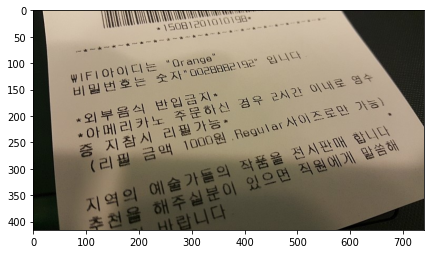

In [331]:
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,7))
plt.imshow(image)
pil_image = Image.fromarray(image)

In [332]:
from PIL import ImageOps, Image, ImageDraw, ImageFont
from itertools import chain

In [333]:
def draw_polygon(img: Image, pts, tags,tag_ori):
    """이미지에 폴리곤을 그린다. illegibility의 여부에 따라 라인 색상이 다르다."""
    img_draw = ImageDraw.Draw(img)

    font = ImageFont.truetype('/opt/ml/upstage_OCR/tools/fonts/NanumSquareRoundB.ttf',size=int(img.height/40))
    # img_draw.rectangle([(pts[0][0],pts[0][1]-20),(pts[0][0]+200,pts[0][1]-20+20)], fill='yellow')
    img_draw.text((pts[0][0],pts[0][1]-int(img.height/40)),tags,(0,0,0),font,align='left')

    pts = list(chain(*pts)) + pts[0]  # flatten 후 첫번째 점을 마지막에 붙인다.
    # 폴리곤 선 너비 지정이 안되어 line으로 표시
    img_draw.line(pts, width=3, fill=(0, 255, 255) if tag_ori == 'Horizontal' else (255,0,0))


In [334]:
def read_img(img, target_h: int = 1000) -> Image:
    """이미지 로드 후 텍스트 영역 폴리곤을 표시하여 반환한다."""
    # load image, annotation
    # img = Image.open(path)
    # img = ImageOps.exif_transpose(img)  # 이미지 정보에 따라 이미지를 회전

    ann_dict = get_ann(img, "http://118.222.179.32:30000/ocr/")

    # resize
    h, w = img.height, img.width
    ratio = target_h/h
    target_w = int(ratio * w)
    # img = img.resize((target_w, target_h))

    # draw polygon
    for val in ann_dict['ocr']['word']:
        poly = val['points']
        tag_ori = val['orientation']
        tag_text = val["text"]
        poly_resize = [[v for v in pt] for pt in poly]
        draw_polygon(img, poly_resize, tag_text, tag_ori)

    return img

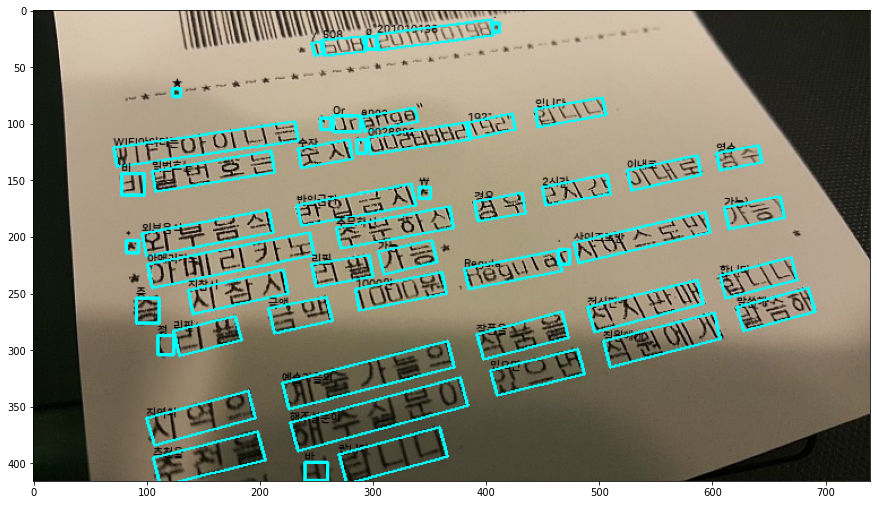

In [335]:
plt.figure(figsize=(15,15))
plt.imshow(read_img(pil_image))

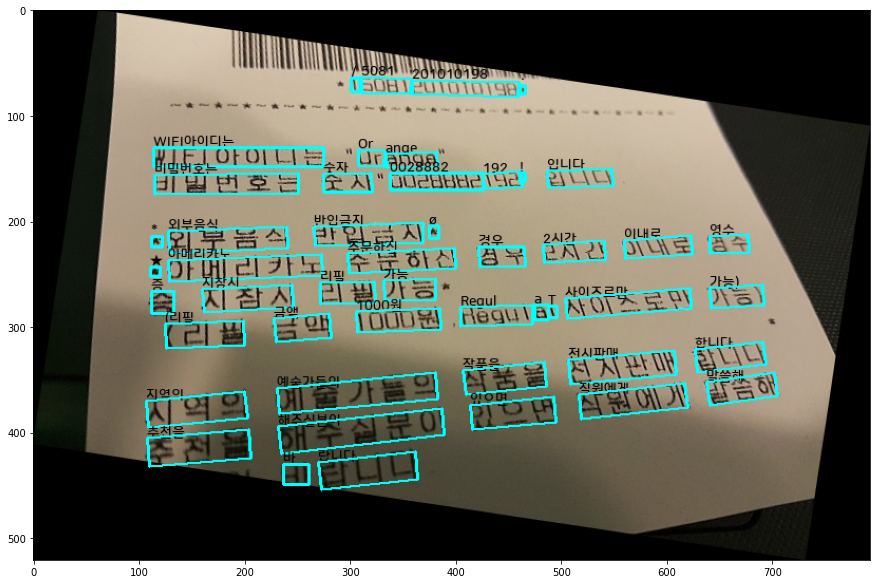

In [336]:
rotated = imutils.rotate_bound(image, -degree)
pil_rotate=Image.fromarray(rotated)
plt.figure(figsize=(15,15))
plt.imshow(read_img(pil_rotate))

In [337]:
# func_list = [
#     A.Rotate(p=1.0, limit=[degree,degree],
#     border_mode= cv2.BORDER_CONSTANT
#     ),
# ]

# alb_transform = A.Compose(func_list)

# transformed = alb_transform(image=image)

# pil_image=Image.fromarray(transformed["image"])
# plt.figure(figsize=(7,7))
# plt.imshow(transformed["image"])

In [338]:
pil_rotate2=Image.fromarray(rotated)
ann_dict2 = get_ann(pil_rotate2,"http://118.222.179.32:30000/ocr/")
annos2 = ann_dict2['ocr']['word']
degree2 = get_degree(annos2)
degree2

{'points': [[114, 130], [275, 130], [275, 148], [114, 148]], 'orientation': 'Horizontal', 'text': 'WIFI아이디는'}


-0.0

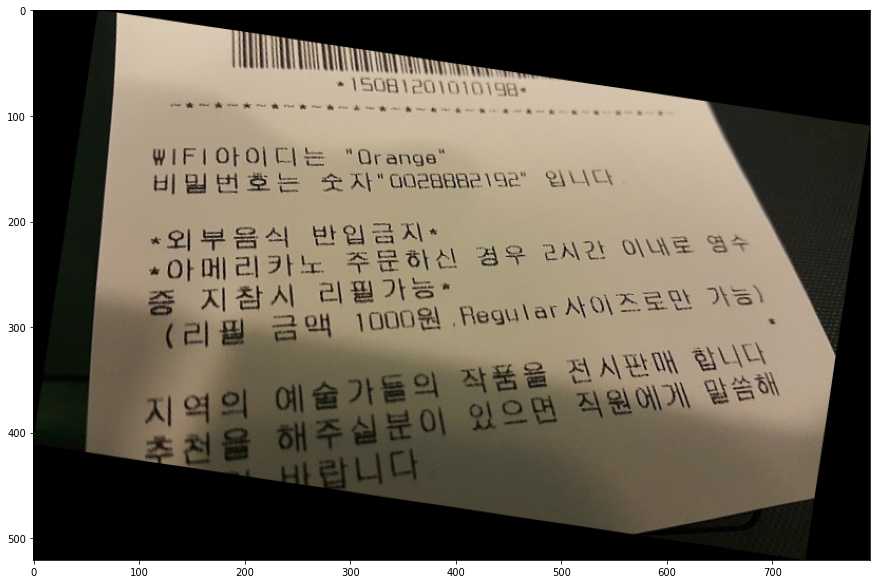

In [339]:
pil_rotate2
plt.figure(figsize=(15,15))
plt.imshow(pil_rotate2)

In [340]:

texts = []
for ind, anno in enumerate(annos2):
  # print((ind, anno['points'][0],anno['points'][1],anno['points'][2],anno['points'][3], anno['text']))
  texts.append((ind, anno['points'][0],anno['points'][1], anno['text'], anno['points'][2],anno['points'][3],)) 

texts_ = sorted(texts, key = lambda x: (x[1][1],x[1][0]))  # y로 정렬 후 x정렬

for i in texts_:
  print(i)

tmp = texts_[0][1][1] # 첫번째 글자의 y좌표 
align = []
phase = []
for text in texts_:
  new_phase = []
  if abs(text[1][1] - tmp) <= ((text[5][1] - text[1][1])/1.5) :  #  같은 라인 판별 / 글자의 반 이내면 
    phase.append(text)
    tmp = min(text[2][1], text[1][1])
  else: # tmp값 벌어지면 다음 라인 취급
    phase.sort(key = lambda x: x[1][0]) # x로 정렬
    align.append(phase)
    new_phase.append(text)
    phase = new_phase
    tmp = min(text[2][1], text[1][1])

phase.sort(key = lambda x: x[1][0])
align.append(phase) # 마지막 줄 추가


# for i in align:
#   print(i)

# print("--------------------")
# for i in align:
#   oneline = ""
#   for n in i:
#     oneline = oneline + n[3]
#   print(oneline)


print("--------------------")
line = []
word = []
for i in align:
    tmp = i[0][1][0]
    for n in i:
      if n[1][0] - tmp <= ((n[2][0]-n[1][0])/len(n[3]))/1.5: 
        word.append(n[3])
        tmp = n[2][0]
      else:
        word.append(" ")
        word.append(n[3])
        tmp = n[2][0]
    line.append(word)
    word = []

for i in line:
  s = "".join(i)
  print(s)

print(line)



(1, [311, 63], [358, 65], '5081', [357, 79], [311, 78])
(0, [301, 64], [309, 64], '/', [309, 77], [301, 77])
(2, [359, 66], [460, 68], '201010198', [459, 82], [359, 79])
(3, [461, 71], [466, 71], '·', [466, 79], [461, 79])
(4, [114, 130], [275, 130], 'WIFI아이디는', [275, 148], [114, 148])
(5, [308, 132], [333, 133], 'Or', [332, 148], [308, 147])
(6, [334, 136], [382, 134], 'ange', [383, 148], [335, 149])
(7, [487, 152], [548, 150], '입니다', [549, 166], [488, 168])
(11, [338, 154], [426, 154], '0028882', [426, 170], [338, 170])
(9, [461, 154], [466, 154], '!', [466, 162], [461, 162])
(10, [275, 155], [320, 154], '숫자', [321, 172], [275, 172])
(8, [426, 155], [462, 152], '192', [463, 167], [427, 169])
(12, [115, 156], [251, 154], '비밀번호는', [251, 173], [115, 174])
(14, [375, 204], [384, 204], 'ø', [384, 216], [375, 216])
(13, [266, 205], [369, 201], '반입금지', [369, 220], [267, 223])
(15, [128, 209], [240, 205], '외부음식', [241, 225], [129, 230])
(17, [112, 214], [122, 214], '*', [122, 224], [112, 224

In [341]:
# 한줄 
# if id pw in line 
#    비밀번호 비번 pw p/w password 


# general receipt image claasification 


In [342]:
# 0 other
# 1 id
# 2 pw 
# 3 other info(화장실, 인스타)
